In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from random import uniform, seed
from math import sqrt
import numpy as np
from Cell2D import Cell2D, draw_array
from matplotlib.colors import LinearSegmentedColormap
from scipy import signal
import seaborn as sns
from matplotlib import cm
from numpy import random
palette = sns.color_palette()
colors = 'white', 'red', 'blue', 'orange'
cmap = LinearSegmentedColormap.from_list('cmap', colors)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Defining a cmap that we can use where zeros (empty houses) will stand out - setting them to black
cmap_show_empty = cm.Greens.copy()
cmap_show_empty.set_bad(color='black')

In [3]:
seed(10)

In [23]:
# Defining a class for the houses
class grid_houses(Cell2D):
    """Represents a grid of Schelling agents."""
    
    def __init__(self, n, prob_empty,kernel,seed):
        """Initializes the attributes.
        
        n: is the dimension of our square numpy array (n x n)

        """
        super().__init__(n)
        self.prob_empty = prob_empty    # probability of empty cells occurring
        self.kernel = kernel
        self.size = n

        choices = np.array([0,1])
        probs1 = [1/3, 1/3, 1/3]
        choices1 = np.array([0.1,0.5,1], dtype = np.int8)
        self.values = np.random.rand(n,n)
        np.random.seed(seed)
        self.array = np.random.choice(2, (n, n), p = [prob_empty, 1-prob_empty]) # randomly choosing which houses are empty, with probability prob_empty

        self.padding = np.ones_like(self.array)
        self.padding[0,:] = np.zeros_like(self.padding[0,:])
        self.padding[1,:] = np.zeros_like(self.padding[1,:])
        self.padding[-1,:] = np.zeros_like(self.padding[-1,:])
        self.padding[-2,:] = np.zeros_like(self.padding[-2,:])
        self.padding[:,0] = np.zeros_like(self.padding[:,0])
        self.padding[:,1] = np.zeros_like(self.padding[:,1])
        self.padding[:,-1] = np.zeros_like(self.padding[:,-1])
        self.padding[:,-2] = np.zeros_like(self.padding[:,-2])

        self.array = np.multiply(self.padding, self.array) # setting the house indicator to zero for the padding
        self.values= np.multiply(self.values, self.array) # sets the house values to zero if there is no house at that spot

    def average_neighbors(self):
        '''
        calculates the of the values of neighbors' house values, where the radius is defined by the kernel matrix. Note - boundary = fill automatically 'pads' the matrix with zeros on the boundary, which leads to lower averages there, so lower house prices near the boundary. We should look into a wrap boundary or possibly filling with a different value, eg average house price.
        :return: array of the averages
        '''
        total = signal.convolve2d(self.values, self.kernel, boundary='wrap', mode='same')
        # adding the number of total grid points
        number = signal.convolve2d(self.array, self.kernel, boundary='wrap', mode='same')

        # finding the average
        average = np.zeros_like(self.array, dtype = float)
        average[2:-2,2:-2] += np.divide(total[2:-2,2:-2],number[2:-2,2:-2])


        # resetting the values to zero for squares that don't have a house
        output = np.multiply(self.array,average)
        output = np.multiply(output, self.array) # setting the house indicator to zero for the padding
        return(output)

    def draw_values(self):
        '''
        Just defined a function to draw the house values so we can draw both a map of houses and a map of house values
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        values = np.ma.masked_where(self.values == 0, self.values)
        return draw_array(values[2:-2,2:-2], cmap = cmap_show_empty)

    def update_values(self, grid_agents, lam):
        '''
        Coding for the function we use to update house prices, at a matrix level. We can use
        :param grid_agents:
        :param lam:
        :return:
        '''
        self.values = lam*self.average_neighbors() + grid_agents.affluences

    def draw_neighbors(self):
        return draw_array(self.average_neighbors())


In [24]:
# Defining a class for the agents
class grid_agents(Cell2D):
    """Represents a grid of Schelling agents."""

    def __init__(self, n, prob_empty,grid_houses):
        """Initializes the attributes.
        """
        super().__init__(n)
        self.prob_emp = prob_empty    # probability of empty cells occurring
        self.size = n
        choices = np.array([0.1,.5,1])
        probs = [1/3, 1/3, 1/3]
        self.affluences = np.random.rand(n,n)
        self.affluences = np.multiply(self.affluences,grid_houses.array)


    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

    def draw_affluences(self):
        '''
        Draws the grid of affluences.
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        affluences = np.ma.masked_where(self.affluences == 0, self.affluences)
        return draw_array(affluences, cmap = cmap_show_empty)

    def swap_people(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        i1 = random.randint(2,self.size-2)
        j1 = random.randint(2,self.size-2)
        i2 = random.randint(2,self.size -2)
        j2 = random.randint(2,self.size-2)

        if j1 != j2 or i1 != i2:
            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                if t1 > t2:
                    self.affluences[i2,j2], self.affluences[i1,j1] = self.affluences[i1,j1],self.affluences[i2,j2]

    def swap_exists(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        print(self.affluences)
        print(grid_houses.values)
        x1 = range(self.array.shape[1])
        x2 = range(self.array.shape[0])
        y1 =range(self.array.shape[1])
        y2 =range(self.array.shape[0])
        x1 = list(x1)
        x2 = list(x2)
        y1 = list(y1)
        y2 = list(y2)
        random.shuffle(x1)
        random.shuffle(x2)
        random.shuffle(y1)
        random.shuffle(y2)

        for i1 in x1:
            for j1 in x2:
                for i2 in y1:
                    for j2 in y2:
                        if j1 != j2 or i1 != i2:
                            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                                # print("t1 =",t1)
                                # print("t2 =",t2)
                                if t1 > t2:
                                    return True
        return False

In [6]:
# kernel used for counting a cell's neighbours
kernel = np.array([[1,1,1, 1, 1],
                   [1,1,1, 1, 1],
                   [1,1, 1, 1,1],
                   [1,1,1, 1, 1],
                   [1,1,1, 1, 1]], dtype=np.int8)

## Running the code (100,000 times)

# Calculating Inequality

In [7]:
def inequality(A):
    """
    Function to find inequality given the aflluence matrix A
    """
    poor = 0
    middle = 0
    rich = 0

    for x in range(np.shape(A)[0]):
        for y in range(np.shape(A)[1]):
            if float(A[x,y]) == 0.1:
                poor += 1
            elif float(A[x,y]) == 0.5:
                middle += 1
            elif float(A[x,y]) == 1.0:
                rich += 1
    sum = poor+middle+rich
    print(f'{np.log(3)}+{poor/sum}*{np.log(poor/sum)}')
    I = np.log(3) + (poor/sum) * np.log(poor/sum) + (middle/sum) * np.log(middle/sum) + (rich/sum) * np.log(rich/sum)
    return(I)

In [11]:
def theil_inequality(A):
    B = A.copy()[2:-2,2:-2]
    avg = np.average(B)
    print('average = ', avg)
    L= B/avg
    T = np.nan_to_num(L* np.log( L ) )
    return T.mean()

In [12]:
inequality_values = []
print(np.log(3))

for x in range(0,10):
    grid_houses1 = grid_houses(19,.1, kernel)
    grid_agents1 = grid_agents(19, 0.1, grid_houses1)
    inequality_values.append(theil_inequality(grid_agents1.affluences))
    print('Theil: ', theil_inequality(grid_agents1.affluences))

1.0986122886681098


TypeError: grid_houses.__init__() missing 1 required positional argument: 'seed'

# Making a graph of (inflation)

# Getting convergence rates for different $\lambda$

In [13]:
def get_convergence(lam, gridsize, p_empty, seed):
    grid_houses1 = grid_houses(gridsize + 4,p_empty, kernel, seed)
    grid_agents1 = grid_agents(gridsize + 4, p_empty, grid_houses1)
    i = 0
    j = 0
    while i < int(gridsize**(2)/3):
        grid_houses1.update_values(grid_agents1, lam)
        g1 = grid_agents1.affluences.copy()
        grid_agents1.swap_people(grid_houses1)
        g2 = grid_agents1.affluences
        if np.array_equal(g1,g2):
            i += 1
        else:
            i = 0
        j += 1
    return j, np.average(grid_houses1.values)

In [ ]:
# graphing 'convergence' for different values of lambda
lambdas = []
convergence = []
inflation = []

for t in range(1,50):
    lam = t/50
    conv, inf = get_convergence(lam, 20, 0.2, 0)
    lambdas.append(lam)
    convergence.append(conv)
    inflation.append(inf)

In [ ]:
plt.plot(lambdas, inflation)
plt.title('Average House Value for different values of lambda',fontsize=20)
plt.xlabel('Lambda',fontsize=20)
plt.ylabel('Average House Value',fontsize=20)
plt.savefig('lambda_inflation_2.pdf',fontsize=20)

In [ ]:
plt.plot(lambdas, convergence)
plt.title('Convergence rate for different values of lambda',fontsize=20)
plt.xlabel('Lambda',fontsize=20)
plt.ylabel('Iterations until convergence',fontsize=20)
plt.savefig('lambda_convergence_2.pdf')

In [ ]:
# graphing 'inflation' for different values of lambda
lambdas = []
convergence = []

for t in range(1,50):
    print(t)
    lam = t/50
    conv = get_convergence(lam, 20, 0.2)
    lambdas.append(lam)
    convergence.append(conv)

# Getting a plot for the report

In [37]:
def get_plots(lam, gridsize, p_empty, file_name):
    i = 0
    j = 0
    maxi = 0
    grid_houses1 = grid_houses(gridsize + 4,p_empty, kernel, seed =0)
    grid_agents1 = grid_agents(gridsize + 4, p_empty, grid_houses1)
    plt.subplot(1,2,1)
    grid_houses1.draw_values()
    plt.colorbar()
    plt.title(f'Initial')
    while i < gridsize**2/3:
        grid_houses1.update_values(grid_agents1, lam)
        g1 = grid_agents1.affluences.copy()
        grid_agents1.swap_people(grid_houses1)
        g2 = grid_agents1.affluences
        if np.array_equal(g1,g2):
            i += 1
        else:
            if i >= maxi:
                maxi = i
                print("maxi = ",maxi)
            i = 0
        j += 1
        if j % 25000 == 0:
            print(j)
    plt.subplot(1,2,2)
    print(f'Average House Value: ',np.average(grid_houses1.values) )
    grid_houses1.draw_values()
    plt.title(f'Converged')
    plt.colorbar()
    plt.savefig(f'{file_name}.pdf')
    #1

maxi =  6
maxi =  58
maxi =  65
maxi =  71
maxi =  115
maxi =  136
maxi =  167
maxi =  200
maxi =  214
25000
50000
75000
100000
125000
150000
175000
maxi =  302
maxi =  336
200000
maxi =  359
225000
250000
maxi =  406
maxi =  417
275000
maxi =  467
300000
325000
maxi =  494
350000
375000
400000
maxi =  552
425000
maxi =  829
450000
475000
500000
525000
550000
575000
600000


KeyboardInterrupt: 

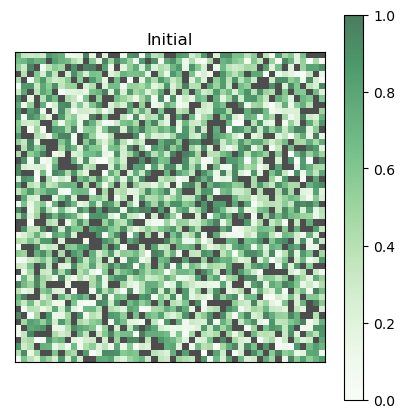

In [45]:
get_plots(0.5, 50, 0.2, 'new_plot')

In [14]:
# Defining a class for the agents
class grid_agents_gamma(Cell2D):
    """Represents a grid of Schelling agents."""

    def __init__(self, n, prob_empty,grid_houses, shape, scale):
        """Initializes the attributes.
        """
        super().__init__(n)
        self.prob_emp = prob_empty    # probability of empty cells occurring
        self.size = n
        choices = np.array([0.1,.5,1])
        probs = [1/3, 1/3, 1/3]
        self.affluences = np.random.gamma(shape, scale, size = (n,n))
        self.affluences = np.multiply(self.affluences,grid_houses.array)


    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

    def draw_affluences(self):
        '''
        Draws the grid of affluences.
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        affluences = np.ma.masked_where(self.affluences == 0, self.affluences)
        return draw_array(affluences, cmap = cmap_show_empty)

    def swap_people(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        i1 = random.randint(2,self.size-2)
        j1 = random.randint(2,self.size-2)
        i2 = random.randint(2,self.size -2)
        j2 = random.randint(2,self.size-2)

        if j1 != j2 or i1 != i2:
            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                if t1 > t2:
                    self.affluences[i2,j2], self.affluences[i1,j1] = self.affluences[i1,j1],self.affluences[i2,j2]

    def swap_exists(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        print(self.affluences)
        print(grid_houses.values)
        x1 = range(self.array.shape[1])
        x2 = range(self.array.shape[0])
        y1 =range(self.array.shape[1])
        y2 =range(self.array.shape[0])
        x1 = list(x1)
        x2 = list(x2)
        y1 = list(y1)
        y2 = list(y2)
        random.shuffle(x1)
        random.shuffle(x2)
        random.shuffle(y1)
        random.shuffle(y2)

        for i1 in x1:
            for j1 in x2:
                for i2 in y1:
                    for j2 in y2:
                        if j1 != j2 or i1 != i2:
                            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                                # print("t1 =",t1)
                                # print("t2 =",t2)
                                if t1 > t2:
                                    return True
        return False

In [15]:
# getting convergence for gamma distributed affluence
def get_gamma_convergence(lam, gridsize, p_empty,gamma_shape,gamma_scale, seed):
    '''Returns the number of iterations required to converge, the average house value, and the theil index in that order'''
    grid_houses1 = grid_houses(gridsize + 4,p_empty, kernel, seed)
    grid_agents1 = grid_agents_gamma(gridsize + 4, p_empty, grid_houses1, gamma_shape, gamma_scale)
    T = theil_inequality(grid_agents1.affluences)
    i = 0
    j = 0
    while i < int(gridsize**(2)):
        grid_houses1.update_values(grid_agents1, lam)
        g1 = grid_agents1.affluences.copy()
        grid_agents1.swap_people(grid_houses1)
        g2 = grid_agents1.affluences
        if np.array_equal(g1,g2):
            i += 1
        else:
            i = 0
        j += 1
    return j, np.average(grid_houses1.values), T

In [16]:
def number_of_it_against_theil(gridsize,steps, seed= None):
     
    #creates the graph for number of iterations against theil index
    teil_values = []
    iterations = []
    for x in range (steps):
            gamma_shape = 10**(-x/50)
            gamma_scale = 1/(2*gamma_shape)
            values = get_gamma_convergence(0.5, gridsize, 0.2,gamma_shape,gamma_scale, seed)
            iterations.append(values[0])
            teil_values.append(values[2])
            
    plt.scatter(teil_values,iterations)
    plt.title(f'Theil Index vs iterations to convergence')
    plt.xlabel(f'Theil Index')
    plt.ylabel(f'Iterations to convergence')
    plt.savefig('thiel_index_graph.pdf')

In [17]:
number_of_it_against_theil(20,20,0)

average =  0.3910543885174378


KeyboardInterrupt: 

In [18]:
plt.scatter(teil_values,iterations)
plt.title(f'Theil Index vs iterations to convergence')
plt.xlabel(f'Theil Index')
plt.ylabel(f'Iterations to convergence')
plt.savefig('thiel_index_graph_1.pdf')

NameError: name 'teil_values' is not defined

## Getting the segregation index


In [34]:
# getting the eigenvalues
def get_eigenvalues(houses):
    real_values = houses.values[2:-2, 2:-2]
    w, v = np.linalg.eig(real_values)
    w.sort()
    w = w[1:]
    values, counts = np.unique(w, return_counts=True)
    p = []
    for i in counts:
        p.append(i/sum(counts))
    p = np.array(p)
    H = np.log(3*(houses.size-4)/5 - sum(np.multiply(p, np.log(p))))
    return H

In [35]:
gridsize = 20
p_empty = 0.2
grid_houses1 = grid_houses(gridsize + 4,p_empty, kernel, seed = None)

In [36]:
print(get_eigenvalues(grid_houses1))

2.7043392559992725


In [ ]:
get_plots(0.5, 20, 0.2, 'new_plot')

KeyboardInterrupt: 

In [ ]:
print(get_eigenvalues(grid_houses1))